<a href="https://colab.research.google.com/github/jlealsarcos/spwla_2022_machine_learning_workshop/blob/main/Data_Leaders_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing

***
<br> 

> #### **Context**
> An e-commerce company needs to rank 
several hundreds sales banners of the website homepage: each customer has a personalized web page. The Data Science team is continuously improving the recommendation algorithms on various perimeters by either adding / removing / refactoring features or modifying the model's architecture and optimization methods. Thus, implementing A/B testing is an essential part of the online evaluation process to assert every move is made in the right direction.  

<br>

**Typical use case:** <br>
In January 2020, a new version of a recommender system algorithm (named **deepranker**) as been deployed on 95% of the e-commerce company visitors' population in France. For the remaining 5%, the flash sales banners have been ordered manually every day by a dedicated team. We'd like to analyze the results and reach conclusion about the algorithm's performance.

<br>

### A/B Test specifications
- **Perimeter**: 
  + France (site_id = 1)
  + All sectors
- **Dates**: 
  + Start: `2020-01-01`
  + End: `2020-01-31`
- **KPI**: Daily Conversion Rate
- **Variants**:
  + var1_merch
  + var2_deepranker

<br>

### A/B Test process
For the modifications brought to the ranking algorithms, we use a frequentist approach to analyze the impacts. Note that other approaches, such as Bayesian, exist as well. Regarding the methodology, we follow these basic steps:

1. Define the different algorithm variants to compare (**A** will be merch while **B** will be deepranker). 

2. State the **null hypothesis (H0)**: _there is no difference between the conversion rates for A and B_ (remember our target KPI for the study is the daily conversion rate). State the **alternative hypothesis (H1)**: _there is a difference between the conversion rates for A and B_

3. Use an A/B test to assert that we get independent and representative groups of users that are exposed to the same variation for the entire A/B test duration, and with respect to the volume we defined (5% for the merch, group A, and 95% for deepranker, group B)

4. Run the A/B test over 31 days.

5. Gather the data by computing the sums of **daily unique visitors** (n) and **daily unique buyers** (c). After 31 days of A/B test, we would get the following conversion rate for a specific variation: 
$$\lambda = \frac{\sum_{i=1}^{31}\text{nb unique buyers day i}}{\sum_{i=1}^{31}\text{nb unique visitors day i}}=\frac{c}{n} $$

6. Compute the **test statistic** value z from $Δλ = λ_B-λ_A$.
> _Statistical test_: **z-Test**. <br>
> In this case, we are dealing with a proportion (variable between 0 and 1). In addition, we have very large samples for both A and B variants. This implies we can invoke the central limit theorem and use the Gaussian distribution as distribution of the test statistic under the null hypothesis.

$$z=\frac{\lambda_B - \lambda_A}{\sqrt{\lambda_c(1-\lambda_c)(\frac{1}{n_B}+\frac{1}{n_A})}} \rightarrow N(0,1) $$
$$ $$ 
$$ \text{avec} \space \space \lambda_c=\frac{n_A\lambda_A+n_B\lambda_B}{n_A+n_B}$$ 

7. From z, compute the **p-value**: the (Gaussian) probability to obtain a result at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. Choose a threshold **α** (usually 5%) under which you would reject the null hypothesis if p-value < α.

# Imports

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data processing

### Load the data

In [ ]:
# Update the path variable based on where your file is located
filename = 'AB_testing_data.csv'
path = '/content/drive/My Drive'
# Load the data
df = pd.read_csv(os.path.join(path, filename))
# Have a look at the raw data
display(df.head(20))
print(f"\nSize of the DataFrame: {df.shape}")

,raisedate,site_id,member_variation,sector,visitors_countd,buyers_countd,orders_countd,turnover
0,01/01/2020,1,var1_merch,fashion,94413,1514,1853,"150 927,00 €"
1,01/01/2020,1,var1_merch,accessories,29878,414,426,"25 588,00 €"
2,01/01/2020,1,var1_merch,travel,77354,459,562,"142 370,00 €"
3,01/01/2020,1,var1_merch,home,71999,758,867,"101 187,00 €"
4,01/01/2020,1,var1_merch,kids,36198,582,696,"15 358,00 €"
5,01/01/2020,1,var1_merch,beauty,22393,295,364,"28 514,00 €"
6,01/01/2020,1,var1_merch,all,125053,4799,6614,"463 944,00 €"
7,01/01/2020,1,var2_deepranker,fashion,1793863,36571,39180,"3 623 850,00 €"
8,01/01/2020,1,var2_deepranker,accessories,567694,5601,6426,"283 544,00 €"
9,01/01/2020,1,var2_deepranker,travel,1469728,15530,19746,"4 832 115,00 €"



Size of the DataFrame: (434, 8)


**Data processing**

Let us put the original data into a new dataset called data and make two modifications. First, the turnover in the orginal dataset is not in readable format to perform analytics on, given those Euro signs. So we parse from each number the relevant amount of Eur. 

Second, the raisedate is not immediately recognised in python as a date, so we transform this in a date using to_datetime, a well known command in panda dataframes.

In [ ]:
data = df.copy()
data.turnover = data.turnover.apply(lambda x: int(x.split(',')[0].replace("\u202f", "")))
data.raisedate = pd.to_datetime(data.raisedate, dayfirst=True)

print("Raw data:")
display(data.head())

Raw data:


,raisedate,site_id,member_variation,sector,visitors_countd,buyers_countd,orders_countd,turnover
0,2020-01-01,1,var1_merch,fashion,94413,1514,1853,150927
1,2020-01-01,1,var1_merch,accessories,29878,414,426,25588
2,2020-01-01,1,var1_merch,travel,77354,459,562,142370
3,2020-01-01,1,var1_merch,home,71999,758,867,101187
4,2020-01-01,1,var1_merch,kids,36198,582,696,15358


<br>

**Data dictionary:**

| Variable | Type | Description |
| :--- | :--- | :--- |
|**raisedate**|`datetime64[ns]`|Visit Date|
|**site_id**|`int64`|Country id {1: France}|
|**member_variation**|`string`|Attributed group for the member|
|**sector**|`string`|Sale sector of the banner (the global results are aggregated under the `all` value)|
|**visitors_countd**|`int64`|Number of unique visitors|
|**buyers_countd**|`int64`|Number of unique buyers|
|**orders_countd**|`int64`|Number of unique orders|
|**turnover**|`int64`|Sum of the generated turnover|

### **Data selection**  
The sector variable is a categorical variable. When the value is `all`, it means **all the sectors** are taken into account. 
We need to:
1. Select only the values corresponding to `sector = all`
2. Devide the dataset into 2 parts:
  - var1_merch
  - var2_deepranker

In [ ]:
data = data[data.sector == 'all']
varA_df = data[data.member_variation == 'var1_merch'] # je veux toutes les lignes dans la colonne member_variation qui sont egales a var1_merch
varB_df = data[data.member_variation == 'var2_deepranker']

print("Merch:")
display(varA_df.head())
print("\nDeepranker:")
display(varB_df.head())

Merch:


,raisedate,site_id,member_variation,sector,visitors_countd,buyers_countd,orders_countd,turnover
6,2020-01-01,1,var1_merch,all,125053,4799,6614,463944
20,2020-01-02,1,var1_merch,all,112796,2710,2973,944532
34,2020-01-03,1,var1_merch,all,121141,4014,4869,531694
48,2020-01-04,1,var1_merch,all,109127,3251,3780,485342
62,2020-01-05,1,var1_merch,all,101652,4265,5897,745569



Deepranker:


,raisedate,site_id,member_variation,sector,visitors_countd,buyers_countd,orders_countd,turnover
13,2020-01-01,1,var2_deepranker,all,2376008,71600,88139,12330783
27,2020-01-02,1,var2_deepranker,all,2143134,59059,68513,11840525
41,2020-01-03,1,var2_deepranker,all,2301692,82273,91504,10008140
55,2020-01-04,1,var2_deepranker,all,2073421,72614,87730,12235923
69,2020-01-05,1,var2_deepranker,all,1931396,48807,52930,12144383


### **Data visualization** 
Let's plot the evolution of some interesting KPIs.

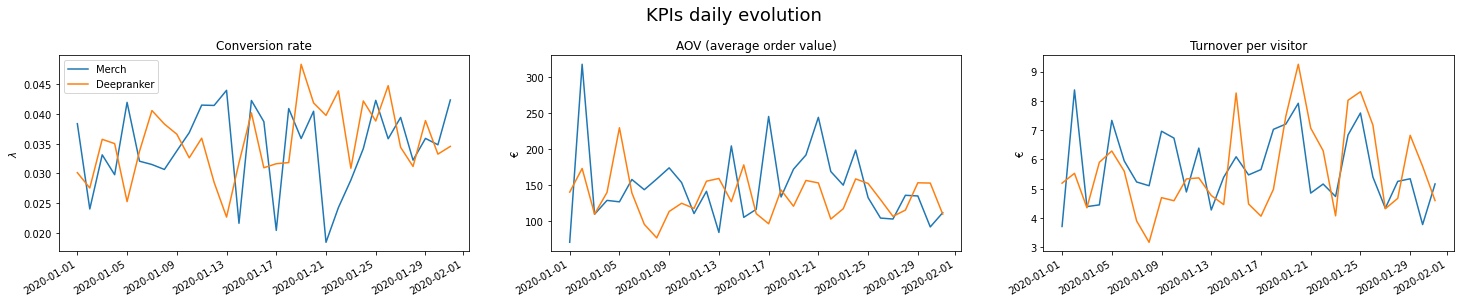

In [ ]:
#@title
fig, axs = plt.subplots(1,3, figsize=(25,4))

dates = varA_df.raisedate.values

axs[0].plot(dates, varA_df.buyers_countd/varA_df.visitors_countd, label='Merch')
axs[0].plot(dates, varB_df.buyers_countd/varB_df.visitors_countd, label='Deepranker')
axs[0].set_ylabel('$\lambda$')
axs[0].set_title('Conversion rate')

axs[1].plot(dates, varA_df.turnover/varA_df.orders_countd, label='Merch')
axs[1].plot(dates, varB_df.turnover/varB_df.orders_countd, label='Deepranker')
axs[1].set_ylabel('€')
axs[1].set_title('AOV (average order value)')

axs[2].plot(dates, varA_df.turnover/varA_df.visitors_countd, label='Merch')
axs[2].plot(dates, varB_df.turnover/varB_df.visitors_countd, label='Deepranker')
axs[2].set_ylabel('€')
axs[2].set_title('Turnover per visitor')

fig.autofmt_xdate()
fig.suptitle('KPIs daily evolution', fontsize=18, y=1.05)
axs[0].legend()
plt.show()

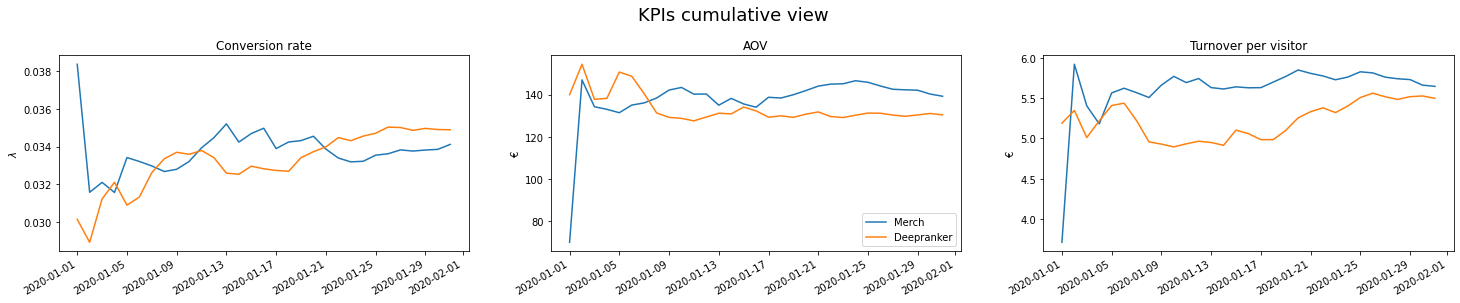

In [ ]:
#@title
# CR
cr_A_cumul = np.array([varA_df.buyers_countd[:i].sum() for i in range(1,32)])/np.array([varA_df.visitors_countd[:i].sum() for i in range(1,32)])
cr_B_cumul = np.array([varB_df.buyers_countd[:i].sum() for i in range(1,32)])/np.array([varB_df.visitors_countd[:i].sum() for i in range(1,32)]) 

# AOV
aov_A_cumul = np.array([varA_df.turnover[:i].sum() for i in range(1,32)])/np.array([varA_df.orders_countd[:i].sum() for i in range(1,32)])
aov_B_cumul = np.array([varB_df.turnover[:i].sum() for i in range(1,32)])/np.array([varB_df.orders_countd[:i].sum() for i in range(1,32)]) 

# Turnover per visitor
tovis_A_cumul = np.array([varA_df.turnover[:i].sum() for i in range(1,32)])/np.array([varA_df.visitors_countd[:i].sum() for i in range(1,32)])
tovis_B_cumul = np.array([varB_df.turnover[:i].sum() for i in range(1,32)])/np.array([varB_df.visitors_countd[:i].sum() for i in range(1,32)]) 

# Plots
fig, axs = plt.subplots(1,3, figsize=(25,4))

axs[0].plot(dates, cr_A_cumul, label='Merch')
axs[0].plot(dates, cr_B_cumul, label='Deepranker')
axs[0].set_ylabel('$\lambda$')
axs[0].set_title('Conversion rate')

axs[1].plot(dates, aov_A_cumul, label='Merch')
axs[1].plot(dates, aov_B_cumul, label='Deepranker')
axs[1].set_ylabel('€')
axs[1].set_title('AOV')

axs[2].plot(dates, tovis_A_cumul, label='Merch')
axs[2].plot(dates, tovis_B_cumul, label='Deepranker')
axs[2].set_ylabel('€')
axs[2].set_title('Turnover per visitor')

fig.autofmt_xdate()
fig.suptitle('KPIs cumulative view', fontsize=18, y=1.05)
axs[1].legend()
plt.show()

# A/B testing in practice
After 31 days of  we have cumulated information on the conversion rates so that we can test if there is a differece between the A and B scenarios. Note that we will not do an A/B test everyday since the results might be unstable. 
<br>

- We want to test the equality of two conversion rates or equivalently two **proportions**. This is our null hypothesis: <br> $H_0$: $\lambda_A=\lambda_B$

- The alternative hypothesis is: <br>$H_1$: $\lambda_A≠\lambda_B$ <br> Statistically speaking this implies a two tailed **z-test**. 

- We will set the significance level of the test **$\alpha$=5%**. This is the conventional level, but any other value can be used. In this case of many observations, we could take for example 1% or smaller. 

<br>



In [ ]:
cr_a = cr_A_cumul[-1]
cr_b = cr_B_cumul[-1]
n_a = varA_df.visitors_countd.sum()
n_b = varB_df.visitors_countd.sum()

print("cr_A:\t", round(cr_a, 5))
print("cr_B:\t", round(cr_b, 5), end='\n\n')

print("n_A:\t", n_a)
print("n_B:\t", n_b)

cr_A:	 0.03412
cr_B:	 0.0349

n_A:	 3274078
n_B:	 62207741


### Z-score
The test statistic computed using the estimated proportions and sample sizes gives the following value:

In [ ]:
cr_c = (n_a*cr_a + n_b*cr_b)/(n_a + n_b)
z = (cr_b - cr_a)/np.sqrt((cr_c*(1-cr_c)*(1/n_a + 1/n_b)))
print(f"z = {round(z, 3)}")

z = 7.491


### P-value

In [ ]:
p_val = 2*(1-stats.norm.cdf(abs(z)))
print(f"p-value = {p_val}")

p-value = 6.816769371198461e-14


Thus, we have that the p-value is much smaller than the significance level: $$\text{p-value} << \alpha $$

<br>

> As a conclusion, we can **reject the null hypothesis $H_0$** and assert that deepranker significantly led to a higher conversion rate over the month of January 2020.



In [ ]:
#@title
from ipywidgets import interact

@interact
def understanind_pvalue(z=round(z, 3)):
  f = plt.figure(figsize=(15,10))
  y_z = stats.norm.pdf(z)

  x = np.linspace(-9, 9, 500)
  y = stats.norm.pdf(x)

  plt.plot(x, y, label='N(0,1)')
  plt.scatter(z, y_z, color='red')
  plt.fill_between(x[x>=1.96], y[x>=1.96], alpha=.3, color='red', label='Rejection area')
  plt.fill_between(x[x<=-1.96], y[x<=-1.96], alpha=.3, color='red')
  plt.fill_between(x[x>=z], y[x>=z], alpha=.2, color='gray', label='p-value = P(|X|≥|z|)')
  plt.fill_between(x[x<=-z], y[x<=-z], alpha=.2, color='gray')
  p_val = 2*(1-stats.norm.cdf(abs(z)))
  plt.annotate(f'p-value = {round(p_val, 3)}', 
               xy=(z+.5,y_z/3),
               xytext=(z+1/2*(3-z),.2), 
               fontsize=14,
               arrowprops={'arrowstyle':'->', 
                           'color': 'gray'})
  plt.annotate('', 
               xy=(-z-.5,y_z/3),
               xytext=(z+1/2*(3-z),.2), 
               fontsize=14,
               arrowprops={'arrowstyle':'->', 
                           'color': 'gray'})
  plt.annotate(f'z = {round(z, 3)}', 
               xy = (z, y_z), 
               xytext = (z,y_z+0.015))
  plt.xlabel('X')
  plt.title('Two tailed test', fontsize=14)
  f.suptitle('UNDERSTANDING THE A/B STATISTICAL TEST', fontsize=18)
  plt.legend()
  plt.show()

interactive(children=(FloatSlider(value=7.491, description='z', max=22.473, min=-7.491), Output()), _dom_class…

# Business insights
While the conversion rates are significantly different, with deepranker outperfming the merch on this KPI, it also seems that deepranker led to a smaller AOV. 
> We have more buyers ==> but each buyer spends less in average per order. 

**Does this globally impact the sales or turnover negatively?**

Another z-test has been applied to another KPI: the turnover per visitor. The results are added to the A/B test results and displayed in the table below. 

<br>

| Variation | $\lambda$ | ∆$\lambda$ | p-value (∆𝜆) | TO/vis | ∆ TO/vis | p-value (∆TO/vis) |
| --------- | ----- | ---------- | -----------  | ----- | -------- | ----------------- |
| **var1_merch** | 3.41% | -- | -- | 5.65€ | -- | -- |
| **var2_deepranker** | 3.49% | +2.3% | 6.8e-14  | 5.50€ | -2.62% | 0.38 |

<br>

> Testing at a significance level of 5%, the decrease in turnover per visitor is not significant since the p-value is 0.38. We can also conclude while the conversion rate increase, this version of deepranker does not seem to bring any additional turnover in the end. 


# Questions for you

Question : Your task is to perform an A/B test. We would like to know if on January 1, 2020 the conversion rate for fashion and beauty with the var1_merch algorithm are significantly different. Use a significance level of 5%.

a): Compute the value of the A/B test statistic.

b): Decide if you are rejecting the null hypothesis or not. Use the above plot for this by sliding the z value to the value of your test statistic. What is the p-value for this test. 